In [2]:
import pandas as pd
from vec_utils import display_highlights, get_model, closest_words, process_paragraphs, get_sentence_list
from gensim.similarities.index import AnnoyIndexer
from histwords import smart_procrustes_align_gensim as align
import gensim
import numpy as np
import matplotlib.pylab as plt
import statsmodels.api as sm
from collections import Counter
import random
from statistics import mean, stdev

In [3]:
def plot_association(word, weed_word1="marijuana", weed_word2="cannabis"):
''' Plots the association between the given word and the two weed_words '''
    d = get_association(word, weed_word1)
    lists = sorted(d.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    f, ax = plt.subplots(1)
    ax.plot(x, y, label=weed_word1.lower())
        #d2 = get_association(word, weed_word2)
    #lists2 = sorted(d2.items()) # sorted by key, return a list of tuples
    #x2, y2 = zip(*lists2) # unpack a list of pairs into two tuples
    #ax.plot(x2, y2, label=weed_word2.lower())
    plt.ylim(ymin=0, ymax=1)
    plt.show()
def get_association(word1, word2="marijuana"):
'''Returns a dictionary of the histword aligned distance over the five year slices '''
    aligned = {year : align(get_model(range(1980, 1985)), get_model(range(year, year+5))) for year in range(1980, 2020, 5)}
    return {year : aligned[year].distance(word2.lower(), word1.lower()) for year in range(1980, 2020, 5)}
def lin_reg(word, word2="marijuana"):
'''Performs a linear regression of the distance between word and word2 over time, 
   returning the coef and the stderr'''
    d = get_association(word, word2)
    X = list(d.keys())
    Y = list(map(lambda x : 100 * x, d.values()))
    X = sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    predictions = model.predict(X)
    return model.params[1], model.bse[1]
def get_intersect_vocab():
    n = 1980
    x = set(get_model(range(1980, 1985)).vocab)
    for n in range(1985, 2020, 5):
        x = x.intersection(set(get_model(range(n, n+5)).vocab))
    return x

def get_lr_df(intersect_vocab):
    aligned = {year : align(get_model(range(1980, 1985)), get_model(range(year, year+5))) for year in range(1980, 2020, 5)}
    def get_association(word1, word2="marijuana"):
        return {year : aligned[year].distance(word2.lower(), word1.lower()) for year in range(1980, 2020, 5)}
    lr_dict = dict()
    for word in intersect_vocab:
        lr_dict[word] = dict()
        coef, stder = lin_reg(word)
        lr_dict[word]['coef'] = coef
        lr_dict[word]['stder'] = stder
    df = pd.DataFrame.from_dict(lr_dict).transpose()
    df['lower'] = df['coef'] - df['stder']
    df['upper'] = df['coef'] + df['stder']
    counter = Counter()
    for paragraph in process_paragraphs(get_df(range(1980, 2020))):
        for word in paragraph:
            counter[word] += 1
    from random import random
    counts = []
    for word in df.index:
        counts.append(counter[word])
    df['count'] = counts
    return df
words = ["heroin", "opium", "lsd", "cocaine", "crime", "criminal", "smuggling", "trafficking", "medical", "medicine", "recreational", "politics", "legalize"] 
def plot_trends(words, df):
    X = words
    Y = [df.loc[word, 'coef'] for word in words]
    std = [df.loc[word, 'stder'] for word in words]
    fig, ax = plt.subplots()
    ax.errorbar(X, Y, yerr=std, linestyle="")
    #ax.set_aspect('equal')
    ax.axhline(y=0, color='k')


[('possession', 0.7254505157470703), ('12', 0.5453032553195953), ('20', 0.5430763363838196), ('nebraska', 0.5426166355609894), ('years', 0.5390388071537018), ('18', 0.536832183599472), ('100', 0.5325329601764679)]


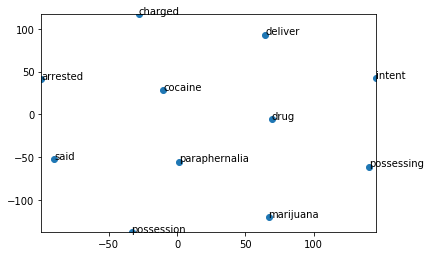

In [10]:
display_highlights(range(1985, 1990), 'newsbank')

[('cannabis', 0.724623292684555), ('use', 0.6913160383701324), ('legalized', 0.627357691526413), ('sales', 0.5514172613620758), ('market', 0.5500284135341644), ('products', 0.536808967590332), ('users', 0.5201565325260162)]
[('marijuana', 0.7246233522891998), ('use', 0.64680615067482), ('products', 0.6081434786319733), ('company', 0.6021248400211334), ('market', 0.5948709845542908), ('legalized', 0.5799350440502167), ('users', 0.5605897307395935)]


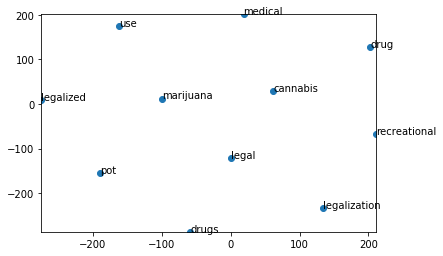

In [9]:
display_highlights(range(2015, 2020))

In [63]:
# for my words, get the % of them that have significant meaning shifts, and get the absolute avg
lr_df = pd.read_csv('lin_reg.csv', header=0, names=['word', 'coef', 'stder', 'sig', 'counnt'])
sig_shifts = len([entry for entry in lr_df.loc[lr_df['word'].isin(words)]['sig'] if entry]) / len(words)
avg_coef = mean([abs(coef) for coef in lr_df.loc[lr_df['word'].isin(words)]['coef']])
print("sig_shifts: ", round(sig_shifts*100, 2))
print("avg_coef: ", round(avg_coef, 3))

sig_shifts:  92.31
avg_coef:  0.653


In [64]:
# for all words, get the % of them that have significant meaning shifts, and get the absolute avg
sig_shifts = len([entry for entry in lr_df['sig'] if entry]) / len(lr_df)
avg_coef = mean([abs(coef) for coef in lr_df['coef']])
print("sig_shifts: ", round(sig_shifts*100, 2))
print("avg_coef: ", round(avg_coef, 3))


sig_shifts:  64.91
avg_coef:  0.299


In [74]:
# Do 5000 trials of 13 random words each and get expected % and sd to have sig meaning shifts and mean and std of absolute avg coef
sig = []
word_samples = [random.sample(list(lr_df['word']), len(words)) for _ in range(5000)]
sig = [len([entry for entry in lr_df.loc[lr_df['word'].isin(words)]['sig'] if entry]) / len(words) for words in word_samples]
coef = [mean([abs(coef) for coef in lr_df.loc[lr_df['word'].isin(words)]['coef']]) for words in wordsamples]
#for _ in range(5000):
 #   random_words = random.sample(list(lr_df['word']), len(words))
 #   sig_shifts = len([entry for entry in lr_df.loc[lr_df['word'].isin(words)]['sig'] if entry]) / len(words)
 #   avg_coef = sum([abs(coef) for coef in lr_df.loc[lr_df['word'].isin(words)]['coef']])/len(words)
    

NameError: name 'wordsamples' is not defined

In [73]:
print("sig_shifts      mean: %f   std: %f" % (mean(sig), stdev(sig)))
print("coef            mean: %f   std: %f" % (mean(coef), stdev(coef)))

sig_shifts      mean: 0.646477   std: 0.135013
coef            mean: 0.299677   std: 0.063850
